In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
%matplotlib inline

/home/udocker/phoenix-worker/environments/python2/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Define x and y
np.random.seed(0)
x = np.random.normal(size=(1000, 500))
y = np.dot(x**2, np.random.normal(size=(500, 1))) + np.dot(x, np.random.normal(size=(500, 1))) + np.random.normal(size=(1000, 1))
y = (1 / (1 + np.exp(-y))).round()
x.shape, y.shape

((1000, 500), (1000, 1))

## Forward propagation

In [4]:
# Initialize weight matrices
params = {}
n_layers = 3
hidden_sizes = [20, 10, 1]
input_size = x.shape[1]

for i in range(n_layers):
    params['w_' + str(i)] = np.random.normal(size=(input_size, hidden_sizes[i]))
    params['b_' + str(i)] = np.random.normal(size=(1, hidden_sizes[i]))
    input_size = hidden_sizes[i]

In [5]:
{k: v.shape for k, v in params.items()}

{'b_0': (1, 20),
 'b_1': (1, 10),
 'b_2': (1, 1),
 'w_0': (500, 20),
 'w_1': (20, 10),
 'w_2': (10, 1)}

In [6]:
# Define activation functions
def relu(x):
    return x * (x > 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
def forward(x, y, params, n_layers, eps=1e-7):
    # Forward pass
    acts = {}
    acts['a_-1'] = np.copy(x)
    for i in range(n_layers):
        z = np.dot(acts['a_' + str(i-1)], params['w_' + str(i)]) + params['b_' + str(i)]
        if i < n_layers - 1:
            acts['a_' + str(i)] = relu(z)
        else:
            acts['a_' + str(i)] = sigmoid(z)

    # Compute loss
    loss = -(y * np.log(acts['a_' + str(i)] + eps) + (1 - y) * np.log(1 - acts['a_' + str(i)] + eps)).mean()    
    return acts, loss, params

In [8]:
acts, loss, params = forward(x, y, params, n_layers)

# Check dimensions of the activations
{k: v.shape for k, v in acts.items()}

{'a_-1': (1000, 500), 'a_0': (1000, 20), 'a_1': (1000, 10), 'a_2': (1000, 1)}

## Backward propagation

In [9]:
def backward(y, acts, params, n_layers):
    grads = {}
    for i in range(n_layers)[::-1]:
        if i == n_layers - 1:
            grads['dz_' + str(i)] = acts['a_' + str(i)] - y
        else:
            grads['da_' + str(i)] = np.dot(grads['dz_' + str(i+1)], params['w_' + str(i+1)].transpose())
            grads['dz_' + str(i)] = grads['da_' + str(i)] * (acts['a_' + str(i)] > 0)
        grads['dw_' + str(i)] = np.dot(acts['a_' + str(i-1)].transpose(), grads['dz_' + str(i)]) * 1.0 / x.shape[0]
        grads['db_' + str(i)] = grads['dz_' + str(i)].sum(axis=0, keepdims=True) * 1.0 / x.shape[0]
    return grads

In [10]:
grads = backward(y, acts, params, n_layers)

# Check dimensions of the gradients
{k: v.shape for k, v in grads.items()}

{'da_0': (1000, 20),
 'da_1': (1000, 10),
 'db_0': (1, 20),
 'db_1': (1, 10),
 'db_2': (1, 1),
 'dw_0': (500, 20),
 'dw_1': (20, 10),
 'dw_2': (10, 1),
 'dz_0': (1000, 20),
 'dz_1': (1000, 10),
 'dz_2': (1000, 1)}

## Update parameters

In [11]:
def update_params(params, grads, n_layers, lr=.001):
    for i in range(n_layers):
        params['w_' + str(i)] -= lr * grads['dw_' + str(i)]
        params['b_' + str(i)] -= lr * grads['db_' + str(i)]
    return params

## Gradient descent

In [12]:
n_iters = 500

In [13]:
loss_dict = {}

### Basic (using all data for each update)

In [14]:
params_ = copy.deepcopy(params)
losses = []
for i in range(n_iters):
    # Forward pass
    acts, loss, params_ = forward(x, y, params_, n_layers)
    losses.append(loss)
    
    # Backward pass
    grads = backward(y, acts, params_, n_layers)
    
    # Update parameters
    params_ = update_params(params_, grads, n_layers)

loss_dict['basic'] = losses

### Mini-batch gradient descent

In [15]:
def gen_batches(x, y, bs=50, seed=0):
    # Shuffle
    np.random.seed(seed)
    ix = np.random.permutation(x.shape[0])
    nb, remains = divmod(x.shape[0], bs)
    if remains > 0:
        nb += 1

    ixs = [ix[i*bs:(i+1)*bs] for i in range(nb)]
    batches = [(x[i], y[i]) for i in ixs]
    return batches

In [16]:
batches = gen_batches(x, y)
len(batches)

20

In [17]:
params_ = copy.deepcopy(params)
losses = []
for i in range(n_iters):
    for j in range(len(batches)):
        # Fetch mini-batch
        x_, y_ = batches[j]
        
        # Forward pass
        acts, loss, params_ = forward(x_, y_, params_, n_layers)
        
        # Backward pass
        grads = backward(y_, acts, params_, n_layers)

        # Update parameters
        params_ = update_params(params_, grads, n_layers)

    # Compute loss after an epoch
    _, loss, _ = forward(x, y, params_, n_layers)
    losses.append(loss)

loss_dict['batch'] = losses

### Momentum

In [18]:
# Initialize velocities
def initialize_velocities(grads):
    vs = {}
    for g in grads:
        vs[g] = np.zeros_like(grads[g])
    return vs

In [19]:
def update_velocities(grads, vs, beta=.9):
    for g in grads:
        vs[g] = beta * vs[g] + (1 - beta) * grads[g]
    return vs

In [20]:
params_ = copy.deepcopy(params)
losses = []
vs = initialize_velocities(grads)

for i in range(n_iters):
    for j in range(len(batches)):
        # Fetch mini-batch
        x_, y_ = batches[j]
        
        # Forward pass
        acts, loss, params_ = forward(x_, y_, params_, n_layers)
        
        # Backward pass
        grads = backward(y_, acts, params_, n_layers)
        
        # Update velocities
        vs = update_velocities(grads, vs)
        
        # Update parameters
        params_ = update_params(params_, vs, n_layers)

    # Compute loss after an epoch
    _, loss, _ = forward(x, y, params_, n_layers)
    losses.append(loss)

loss_dict['momentum'] = losses

### RMSprop

In [21]:
# Initialize velocities
def initialize_squareds(grads):
    ss = {}
    for g in grads:
        ss[g] = np.zeros_like(grads[g])
    return ss

In [22]:
def update_squareds(grads, ss, beta=.9, eps=1e-7):
    for g in grads:
        ss[g] = beta * ss[g] + (1 - beta) * grads[g]**2
        grads[g] /= np.sqrt(ss[g]) + eps
    return ss, grads

In [23]:
params_ = copy.deepcopy(params)
losses = []
ss = initialize_squareds(grads)

for i in range(n_iters):
    for j in range(len(batches)):
        # Fetch mini-batch
        x_, y_ = batches[j]
        
        # Forward pass
        acts, loss, params_ = forward(x_, y_, params_, n_layers)
        
        # Backward pass
        grads = backward(y_, acts, params_, n_layers)
        
        # Update squareds
        ss, grads = update_squareds(grads, ss)
        
        # Update parameters
        params_ = update_params(params_, grads, n_layers)

    # Compute loss after an epoch
    _, loss, _ = forward(x, y, params_, n_layers)
    losses.append(loss)

loss_dict['rmsprop'] = losses

### Adam

In [25]:
# Initialize velocities
def initialize_adam(grads):
    vs = {}
    ss = {}
    for g in grads:
        vs[g] = np.zeros_like(grads[g])
        ss[g] = np.zeros_like(grads[g])
    return vs, ss

In [26]:
def update_adam(grads, vs, ss, beta_1=0.9, beta_2=0.999, eps=1e-7):
    for g in grads:
        vs[g] = beta_1 * vs[g] + (1 - beta_1) * grads[g]
        ss[g] = beta_2 * ss[g] + (1 - beta_2) * grads[g]**2
        grads[g] = vs[g] / (np.sqrt(ss[g]) + eps)
    return vs, ss, grads

In [29]:
params_ = copy.deepcopy(params)
losses = []
vs, ss = initialize_adam(grads)

for i in range(n_iters):
    for j in range(len(batches)):
        # Fetch mini-batch
        x_, y_ = batches[j]
        
        # Forward pass
        acts, loss, params_ = forward(x_, y_, params_, n_layers)
        
        # Backward pass
        grads = backward(y_, acts, params_, n_layers)
        
        # Update Adam
        vs, ss, grads = update_adam(grads, vs, ss)
        
        # Update parameters
        params_ = update_params(params_, grads, n_layers)

    # Compute loss after an epoch
    _, loss, _ = forward(x, y, params_, n_layers)
    losses.append(loss)

loss_dict['adam'] = losses

### Compare losses

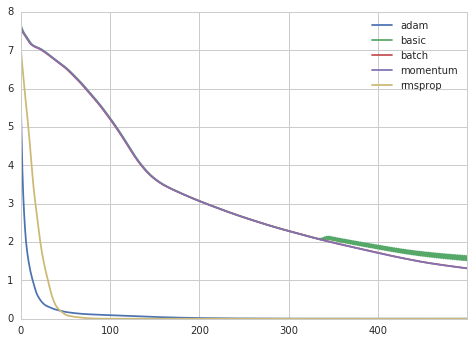

In [34]:
pd.DataFrame(loss_dict).plot()